Data from [here](http://insideairbnb.com/get-the-data.html).

From North Holland, Amsterdam
listings.csv was scraped August 9th, 2019


http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf `-->` using text for regression

# Goal: 

The two variables that have the biggest importance are price and availability_x.

- Space of listing
- Amenities provided
- Location (gonna have to familiarize myself with Amsterdam places)


# Introduction

Intro here...


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from scipy import stats
from scipy.stats import norm
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Looking at the Data

In [2]:
df = pd.read_csv('data/20190808/listings.csv')
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190808195507,2019-08-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.12
1,20168,https://www.airbnb.com/rooms/20168,20190808195507,2019-08-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.46
2,25428,https://www.airbnb.com/rooms/25428,20190808195507,2019-08-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.16


In [3]:
print('There are', df.shape[0], 'observations and', df.shape[1], 'variables.')

There are 20677 observations and 106 variables.


As we can see, there are numerous variables in this dataset. Some are more useful than others. It would be helpful to understand briefly what these variables are, and though some are self-explanatory, others are not. Below I list some of the variables I had trouble understanding and their meaning after some research:

__Descriptions of some unclear variables__

| __Variable Name__ 	| __Description__ 	|
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `space` 	| A more detailed description of the property.  	|
| `experienced_offered` 	| Unclear what this means (perhaps related to [Airbnb Experiences](https://blog.atairbnb.com/what-are-airbnb-experiences/)?), but all of the properties have this variable as `none`, so it is safe to drop this column completely since it will not help our model. 	|
| `access` 	| Textual description of how much space is accessible by the guest. Some are missing. 	|
| `interaction` 	| How the guest can interact with the host. 	|
| `neighbourhood_cleansed`, `neighbourhood_group_cleansed` 	| A variable that was further processed from the `neighbourhood` column. All values for `neighbourhood_group_cleansed` are missing, so it would be safe to drop it. 	|
| `market` and `smart_location` 	| Location of these listings. Given the inconsistency of `smart_location`, I will drop it in favor of `neighbourhood_cleansed`. 	|
| `minimum_minimum_nights`, `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights` 	| Refers to the maximum or minimum amount of nights that a property has had in terms of their `minimum_nights` and `maximum_nights`. For simplicity, these columns will be dropped. 	|
| `availability_30`, `availability_60`, `availability_90`, `availability_365` 	| The number of days that the property can be rented within the next 30, 60, 90 and 365 days. As if Jan. 1st, 2019, [Airbnb regulations in Amsterdam state that properties can only be rented out for 30 days](https://www.airbnb.com/help/article/860/amsterdam). So, I will only use `availability_30`. 	|
| `number_of_reviews_ltm` 	| The number of reviews in the last twelve months (ltm). `number_of_reviews` will be used instead.	|
| `calculated_host_listings_count`, `calculated_host_listings_count_entire_homes`, `calculated_host_listings_count_private_rooms`, `calculated_host_listings_count_shared_rooms` 	| The calculated number of listings this particular host has, split into different types of properties. For simplicity, I will just use `calculated_host_listings_count` and drop the rest. 	|

Now that I have some general understanding of the variables in this dataset, it is time to make some educated guesses as to what variables could greatly influence `price`. 

Off the top of my head, here are some factors that I expect to be greatly influence the `price` of a listing:

| __Variable Name__ 	| __Why I Think It's Influential__ 	|
|--------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `host_is_superhost` 	| If a host performs superbly, then that host can become a Superhost. Given this status boost, they may price their properties more.  	|
| `neighbourhood_cleansed` 	| Like in real-estate, location is a huge factor in determining the price of a listing. I chose using this cleansed version since it seems to have already been preprocessed from `neighbourhood` by Inside Airbnb. 	|
| `amenities` 	| The number of amenities as well as what those amenities are could be a big factor in terms of pricing a listing on Airbnb. More amenities available to the guest would mean that that guest would have to pay more. 	|
| `square_feet` 	| It makes sense to think that the size of the property would influence price. 	|
| `review_scores_rating` 	| The overall rating of the listing could influence price. 	|

__Might have to remove the following paragraph if I can't think of how to perform SA on description; easier to do so with reviews__
Some other variables that I think would be interesting to look at would be between the decription of the property and the price. Is there some sort of correlation between what a host puts in their description and the price of the property? Can this be extended to the kinds of reviews that the property received? Is there some relationship between the sentiment of such descriptions and the property's reviews and the price of that property? Though it would be difficult to incorporate such observations into the final model, it would nonetheless be interesting to look into. 

Before going into the missing data, it would help to lessen the amount of variables I have to analyze. There are two cases I will consider: whether or not a variable repeats the same value for each observation in the dataset, whether or not variable is inherently useful in predicting the price.

For the first case, there could be several variables that have the same value for each property. It could very well be the case that since this dataset is for Amsterdam listings only, all properties will have `Netherlands` for the `country` variable. I will delete such variables since they provide no additional information to price. 

For the second case, it is important to consider that there are variables that will not be helpful in predicting the price, such as the URL of the listing `listing_url` and the ID of discerning when the data was scraped `scrape_id`. 

In [4]:
# Case 1: Which variables have only one unique value?

delete_vars = [col for col in df.columns if len(df[col].unique()) == 1]
print(delete_vars)
        
# Delete them
df_clean = df.drop(delete_vars, axis = 1)

['scrape_id', 'experiences_offered', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'country_code', 'country', 'has_availability', 'requires_license', 'is_business_travel_ready']


In [5]:
# Case 2: What variables left are inherently not helpful in predicting price?

# Delete URLs
delete_vars = [col for col in df_clean.columns if 'url' in col]
df_clean = df_clean.drop(delete_vars, axis = 1)

# Delete IDs 
delete_vars = [col for col in df_clean.columns if 'id' in col]
df_clean = df_clean.drop(delete_vars, axis = 1)

# Delete full textual data (besides description for now)
full_text_columns = ['host_name', 'name', 'summary', 'space', 'neighborhood_overview', 'notes', 'house_rules', 'access', 'interaction', 'transit', 'host_about']
df_clean = df_clean.drop(full_text_columns, axis = 1)

# Delete scraping information
df_clean = df_clean.drop(['last_scraped'], axis = 1)
df_clean = df_clean.drop(['calendar_last_scraped'], axis = 1)

In [6]:
print('After initially removing some inherently useless and non-unique variables, there are now', df_clean.shape[1], 'variables left.')

After initially removing some inherently useless and non-unique variables, there are now 73 variables left.


# What's Missing?

With less variables to look at, I can now analyze the missing variables.
Let's take a look at what variables are missing.

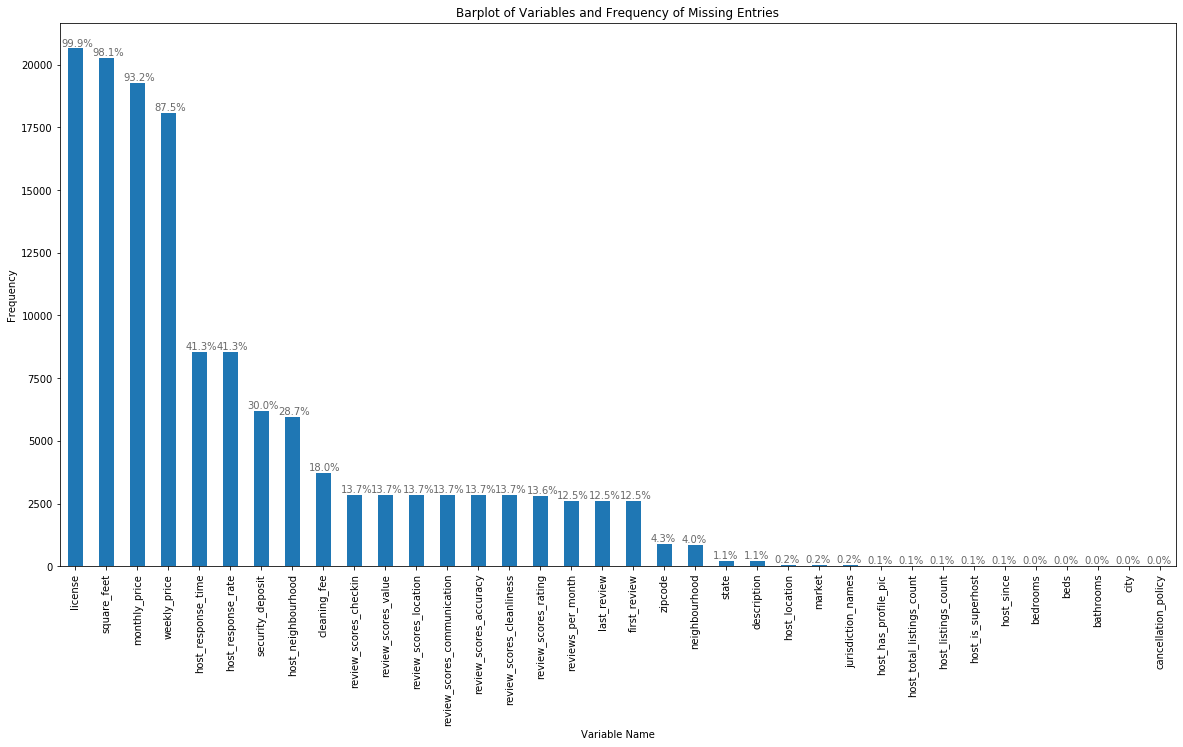

In [7]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending = False)

ax = missing.plot(kind='bar', figsize=(20, 10))
ax.set_alpha(0.8)
ax.set_title("Barplot of Variables and Frequency of Missing Entries")
ax.set_ylabel("Frequency")
ax.set_xlabel('Variable Name')

# Set frequency text
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x() - 0.2, i.get_height() + 100, \
            str(round((i.get_height()/len(df_clean))*100, 1))+'%', fontsize=10,
                color='dimgrey')

Let's look at these one by one, starting from the variable with the most missing entry.

- `license` corresponds to the host's license number, as some cities require this in order to list their home on Airbnb. It is also missing in about 99.9% of the dataset, and so it would seem a majority of cities do not require such a license. Given this information, I will drop this column.

In [8]:
df_clean = df_clean.drop(['license'], axis = 1)

- `square_feet` is among these variables (in fact, it is the second variable with the greatest amount of missing entries). It would seem that most properties do not list the size of that property on the Airbnb website, despite my initial expectations on how important I thought it would be. So, I will drop this column from the dataset.

In [9]:
df_clean = df_clean.drop(['square_feet'], axis = 1)

- `monthly_price` and `weekly_price` are both missing in over 85% of the data, and so I will drop them. Also, I am only interested in `price`.

In [10]:
df_clean = df_clean.drop(['monthly_price', 'weekly_price'], axis = 1)


- `host_response_time` and `host_response_rate` have the same amount missing in the data (41.3%). Is there some sort of relationship? 

In [11]:
# Are the observations missing host_response_time the same as the ones missing host_response_rate?
all(df_clean[df_clean['host_response_time'].isna()].index == df_clean[df_clean['host_response_rate'].isna()].index)

True

All observations missing `host_response_time` are the same as the ones missing `host_response_rate` ie. if there is no data for `host_response_rate`, then there would be none for `host_response_time`. Why would this happen? It could be that a host cannot respond to a guest if their property has never been used, or their property was in the process of being used at the time this data was scraped.

Given this, I will impute the missing data with its own category: `no_response`.

In [12]:
df_clean['host_response_time'] = df_clean['host_response_time'].fillna('no response')
df_clean['host_response_rate'] = df_clean['host_response_rate'].fillna('no response')

- `security_deposit` corresponds to how much the host requires as a security deposit for the property. I will interpret missing values as the host not needing a security deposit for the property ie. $0. I will also preprocess the dollar values to actual floats.

In [13]:
def dollar_str_to_int(dollar_str):
    """
    Convert dollars in a column to a float.
    """
    return float(dollar_str.replace('$', '').replace(',', ''))

In [14]:
df_clean['security_deposit'] = df_clean['security_deposit'].fillna('$0')
df_clean['security_deposit'] = df_clean['security_deposit'].apply(dollar_str_to_int)

- `host_neighbourhood` corresponds to the neighborhood that the host is from. Location is already explained by `neighbourhood_cleansed`, so I will drop this column.

In [15]:
df_clean = df_clean.drop(['host_neighbourhood'], axis = 1)

- `cleaning_fee` is how much the host charges if the host has to clean to property after the guest has finished their stay. I will treat this the same way I treated `security_deposit`.

In [16]:
df_clean['cleaning_fee'] = df_clean['cleaning_fee'].fillna('$0')
df_clean['cleaning_fee'] = df_clean['cleaning_fee'].apply(dollar_str_to_int)

- The `review_scores_x` variables have almost the same amount missing in the data. Given that these are the ratings of particular properties, it would not be appropriate to drop these columns. It would also make sense that for listed properties not used by guests, there would be no value for it. As such, I will impute these missing variables with another category: `no review`. This introduces another problem, as the original column consisted of quantitative data ie. a number to rate the property. Using `no review` would require me to change the column to use qualitative data. I will discuss this more further below. 

In [17]:
df_clean['review_scores_checkin'] = df_clean['review_scores_checkin'].fillna('no review')
df_clean['review_scores_value'] = df_clean['review_scores_value'].fillna('no review')
df_clean['review_scores_location'] = df_clean['review_scores_location'].fillna('no review')
df_clean['review_scores_communication'] = df_clean['review_scores_communication'].fillna('no review')
df_clean['review_scores_accuracy'] = df_clean['review_scores_accuracy'].fillna('no review')
df_clean['review_scores_cleanliness'] = df_clean['review_scores_cleanliness'].fillna('no review')
df_clean['review_scores_rating'] = df_clean['review_scores_rating'].fillna('no review')

- `reviews_per_month` counts the number of reviews the property had at that month. Missing values will be imputed with a 0.

In [18]:
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

- `last_review`, and `first_review` have the same amount of missing variables. Again, it would make sense that unused properties would have no reviews. Additionally, some properties might have guests that choose to not leave a review. A small amount of data is missing for these columns, about 12%, and values in these columns are dates. So, I will use the number of days from the day this data was scraped (Aug. 8th, 2019 according to `scrape_id`) to the date in `last_review` and `first_review`. Missing values will be imputed with a 0, since no review was made for that property.

In [19]:
df_clean['first_review'] = pd.to_datetime(df_clean['first_review']) # Month first 
df_clean['last_review'] = pd.to_datetime(df_clean['last_review']) 

df_clean['days_since_first_review'] = (datetime(2019, 8, 8) - df_clean['first_review']).dt.days
df_clean['days_since_last_review'] = (datetime(2019, 8, 8) - df_clean['last_review']).dt.days

df_clean['days_since_first_review'] = df_clean['days_since_first_review'].fillna(0)
df_clean['days_since_last_review'] = df_clean['days_since_last_review'].fillna(0)

- `zipcode`, `neighbourhood`, `city`, and `state` are all location variables. Since I already intend to use `neighbourhood_cleansed`, I will drop the `neighbourhood` column. `city` was given by the host, and given the inconsistency of this variable, I will drop it in favor of `neighbourhood_cleansed`. The same can be said for `state` and `zipcode`.

In [20]:
df_clean = df_clean.drop(['neighbourhood', 'zipcode', 'state', 'city'], axis = 1)

- `description` is a full textual variable, and so I will impute missing data as an empty string.

In [21]:
df_clean['description'] = df_clean['description'].fillna('')

- `host_location` refers to where the host is from. I think it would be interesting to explore how different hosts from around the world price their Airbnb properties, and so I will keep this variable for now. I will impute the missing values with the mode of `host_location`. I will do the same with `market` and `jurisdiction_names`.

In [22]:
df_clean['host_location'] = df_clean['host_location'].fillna(df_clean['host_location'].describe()['top'])
df_clean['market'] = df_clean['market'].fillna(df_clean['market'].describe()['top'])
df_clean['jurisdiction_names'] = df_clean['jurisdiction_names'].fillna(df_clean['jurisdiction_names'].describe()['top'])

- I think it would be interesting to explore how `host_has_profile_pic` affects how popular a particular listing is booked. [There has been some research into how having a picture on LinkedIn increases your chances of being noticed](https://www.linkedin.com/business/sales/blog/b2b-sales/picture-perfect--make-a-great-first-impression-with-your-linkedi) - I wonder if the same can be said for Airbnb properties. Again, I will impute missing values with the mode.

In [23]:
df_clean['host_has_profile_pic'] = df_clean['host_has_profile_pic'].fillna(df_clean['host_has_profile_pic'].describe()['top'])

- `host_total_listings_count` and `host_listings_count` both refer to the number of listings a host has. I already mentioned before that I will only be using `calculated_host_listings_count`, so I will drop these two columns.

In [24]:
df_clean = df_clean.drop(['host_total_listings_count', 'host_listings_count'], axis = 1)

- Missing values for `host_is_superhost` will be imputed with the mode.

In [25]:
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].fillna(df_clean['host_is_superhost'].describe()['top'])

- `host_since` shows when the host first listed their property on Airbnb. What would be interesting to look at would be how the experience ie. the length of time that host has been hosting their particular property is related to the price. Since these are time stamps, I will keep this for a time series analysis later on. This will be dropped later in favor of `days_as_host`, which will be computed as the number of days the person has been a host since Aug. 8, 2019.  As for the missing rows, I will delete them from the dataset, considering that it would be difficult to impute them and there are only 12 such observations.

In [26]:
df_clean['host_since'] = pd.to_datetime(df_clean['host_since']) 
df_clean['days_as_host'] = (datetime(2019, 8, 8) - df_clean['host_since']).dt.days
df_clean = df_clean.dropna(subset = ['host_since'])

- Rows that are missing the remaining variables (`bedrooms` till `cancellation_policy`) will be dropped, as they make up such a small amount of our dataset. Losing them will not affect our prediction model too much. 

In [27]:
df_clean = df_clean.dropna(subset = ['bedrooms', 'beds', 'bathrooms', 'cancellation_policy'])

In [28]:
print('Before Dealing with Missing Variables:', df.shape[0], 'observations and', df.shape[1], 'variables.')
print('After Dealing with Missing Variables:', df_clean.shape[0], 'observations and', df_clean.shape[1], 'variables.')

Before Dealing with Missing Variables: 20677 observations and 106 variables.
After Dealing with Missing Variables: 20643 observations and 65 variables.


After some cleaning, I took off approximately 0.16% from the original dataset, and so I have not lost too much information. What variables are we left with?

In [29]:
for col in df_clean.columns:
    print(col)

description
host_since
host_location
host_response_time
host_response_rate
host_is_superhost
host_verifications
host_has_profile_pic
street
neighbourhood_cleansed
market
smart_location
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
jurisdiction_names
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
calcu

# EDA - `Price`

Now, I will look more into `price`, and how it is distributed in this dataset.

First, since it is a string, I will convert it into a float.

In [30]:
df_clean['price'] = df['price'].apply(dollar_str_to_int)
df_clean['price'].describe()

count    20643.000000
mean       159.128324
std        162.520446
min          0.000000
25%         99.000000
50%        130.000000
75%        180.000000
max       8915.000000
Name: price, dtype: float64

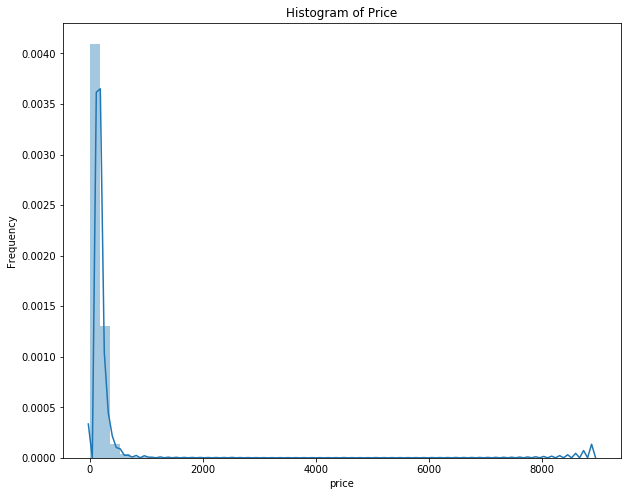

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of Price')
ax.set_ylabel('Frequency')
ax = sns.distplot(df_clean['price'])
plt.show()

In [32]:
print('Skewness:', df_clean['price'].skew())
print('Kurtosis:', df_clean['price'].kurtosis())

Skewness: 25.790751572268885
Kurtosis: 1108.9703728876766


Some things to note from this graph and the statistics:

- This is a unimodal distribution heavily skewed towards the right.
- The average price for Amsterdam Airbnb properties is \$159.
- The minimum price is \$0, which may be a mistake, and so I should investigate this observation more.
- The maximum price is \$8,915, which is crazy considering the price of other properties in the area. Properties like these may be outliers.
- The graph is heavily skewed to the right, shown by both the graph and the measure of skewness.
- Kurtosis measures the tailedness and larger values correspond to distributions with a heavier tale, such as the case here.

Given how skewed this data is, it is not appropriate to use the average price. Using the median as the measure of central tendency is better than using the mean, as the mean is pulled towards the tail of the distribution. Additionally, I will have to transform this data and make it as normal as possible, given the fact that regression models do not perform well when the data is non-normal. 

In [33]:
print('The median price of an Amsterdam Airbnb property is', df_clean['price'].median(), 'dollars.')

The median price of an Amsterdam Airbnb property is 130.0 dollars.


It is extremely apparent that `price` is not normally distributed. But, I will still test its normality to be consistent. I will do this using `scipy`.

In [34]:
def is_normal(data):
    """
    Returns True if the data given is normal ie. the p-value is less than 0.05. 
    If not, then return False.
    """

    _, p = stats.normaltest(df_clean['price'])
    if p < 0.05:
        return False
    else:
        return True

In [35]:
if is_normal(df_clean['price']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


Another way to visually represent the normality of a distribution is using a probability plot, which essentially plots how similar one distribution is to another distribution (the normal distribution, in this case).

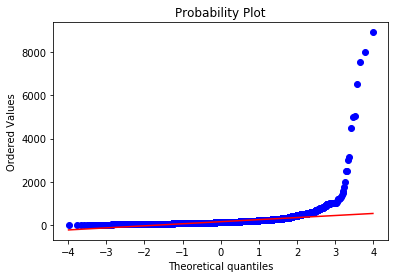

In [36]:
res = stats.probplot(df_clean['price'], plot=plt)

If `price` were normal, then the blue dots would closely follow the red line. However, there are many deviations from this line, especially at the end where there may be outliers present ie. homes that are extremely expensive. 


## A Free Amsterdam Home?
I mentioned earlier that the minimum amount for `price` is \$0. Let's look more into this.

In [37]:
# What properties are listed as having $0 in price?
df_clean[df_clean['price'] == 0]

,description,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_has_profile_pic,street,neighbourhood_cleansed,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,days_since_first_review,days_since_last_review,days_as_host
12535,This studio is 15min tram ride away from city ...,2014-02-05,"Amsterdam, North Holland, Netherlands",within an hour,100%,f,"['email', 'phone', 'reviews']",t,"Amsterdam, Noord-Holland, Netherlands",Bos en Lommer,...,f,f,2,2,0,0,0.5,711.0,4.0,2010.0


Since only one property is missing the price, then I will drop it from my dataset.

In [38]:
df_clean = df_clean[df_clean.price != 0]

In [39]:
# What's the minimum amount now?
print('The least expensive property in this dataset is', df_clean['price'].describe()['min'], 'dollars.')

The least expensive property in this dataset is 9.0 dollars.


## Transforming `price`

Given the right-skewedness of the distribution, I will use a log-transformation to transform the data. This will be used in training the model. `price` will be kept for EDA purposes.

In [40]:
df_clean['log_price'] = np.log(df_clean['price'])

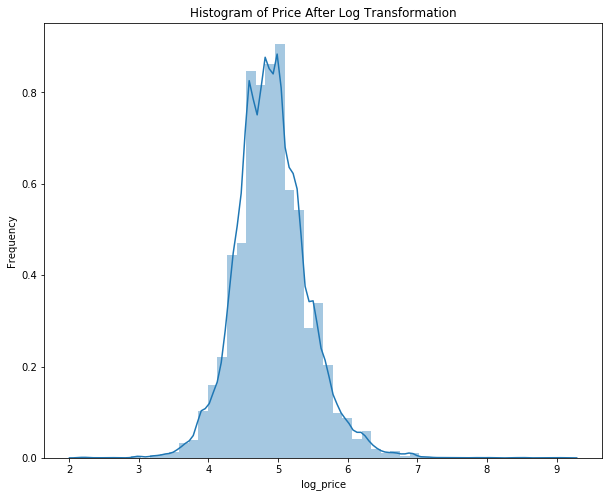

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of Price After Log Transformation')
ax.set_ylabel('Frequency')
ax = sns.distplot(df_clean['log_price'])
plt.show()

In [42]:
print('Skewness:', df_clean['log_price'].skew())
print('Kurtosis:', df_clean['log_price'].kurtosis())

Skewness: 0.5016433750312589
Kurtosis: 2.332766950843304


In [43]:
if is_normal(df_clean['log_price']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


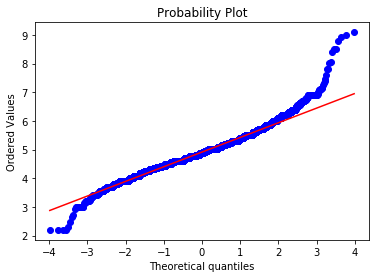

In [44]:
res = stats.probplot(df_clean['log_price'], plot=plt)

Though our normal test still claims the data is not normal, it is close enough to normality. The probability plot and histogram both show this visually.

I have also tried other types of transformations by ["going down the ladder of powers"](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_03.pdf), but they did not perform as well as a log transformation. Below is a visualization of that. As you can see from the histograms, the data becomes more skewed the further down the ladder I go.

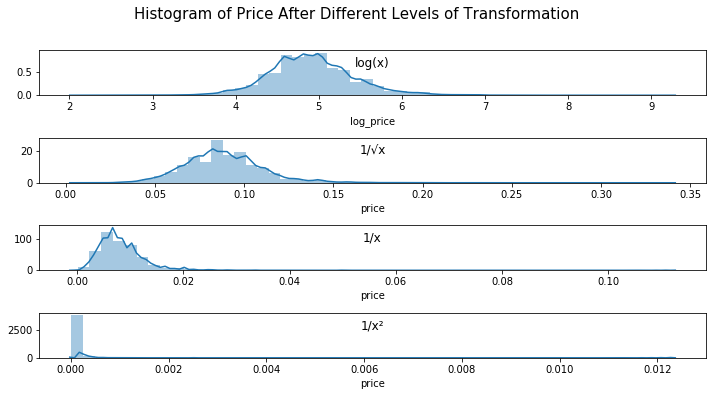

In [45]:
recip_root_price = df_clean['price'].apply(lambda x: 1 / math.sqrt(x)) # reciprocal square root = 1 / sqrt(x)
recip_price = df_clean['price'].apply(lambda x: 1 / x) # reciprocal = 1 / x
recip_sqr_price =  df_clean['price'].apply(lambda x: 1 / math.pow(x, 2)) # reciprocal squared = 1 / x^2

fig, axes = plt.subplots(figsize=(10 , 5), nrows = 4)
fig.suptitle('Histogram of Price After Different Levels of Transformation', y = 1.09, fontsize=15)

y_title_margin = 0.5
axes[0].set_title('log(x)', y = y_title_margin)
axes[1].set_title(u'1/\u221Ax', y = y_title_margin)
axes[2].set_title("1/x", y = y_title_margin)
axes[3].set_title(u"1/x\u00B2", y = y_title_margin)

sns.distplot(df_clean['log_price'], ax = axes[0])
sns.distplot(recip_root_price, ax = axes[1])
sns.distplot(recip_price, ax = axes[2])
sns.distplot(recip_sqr_price, ax = axes[3])

fig.tight_layout()

plt.show()

Note the x-axis, which is getting smaller after each transformation. This means that the data is being grouped more and more towards the left ie. smaller numbers.

# EDA - The Rest of the Independent Variables

In [46]:
print('To recap, there are', df_clean.shape[1], 'variables.')

To recap, there are 66 variables.


## Datetime Variables

In [47]:
# What are the datetime variables?
datetime_vars = [col for col in df_clean.columns if 'time' in str(df_clean[col].dtype)]

print(datetime_vars)

['host_since', 'first_review', 'last_review']


**Question:** When were people listing their properties? Why? How long? What are the trends?

In [48]:
print('In this dataset, the first host joined on', df_clean['host_since'].describe()['first'])
print('The last host joined on', df_clean['host_since'].describe()['last'])

In this dataset, the first host joined on 2008-09-24 00:00:00
The last host joined on 2019-08-08 00:00:00


The dataset describes host joining over an 11 year timespan, from 2008 to 2019. Interestingly enough, Airbnb was founded in August of 2008, so analyzing the trend of hosts joining will show how Airbnb has grown in this timespan.

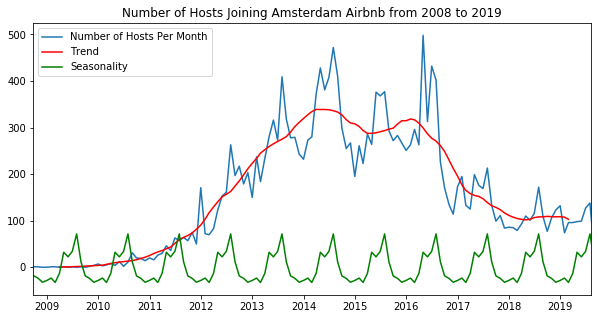

In [49]:
fig, ax = plt.subplots(figsize=(10 , 5))

plt.title('Number of Hosts Joining Amsterdam Airbnb from 2008 to 2019')
plt.plot(df_clean.set_index('host_since').resample('M', 'size'), label = 'Number of Hosts Per Month')

# Decompose using additive model
decomp = seasonal_decompose(df_clean.set_index('host_since').resample('M', 'size'))
plt.plot(decomp.trend.index, decomp.trend, c = 'r', label = 'Trend')
plt.plot(decomp.trend.index, decomp.seasonal, c = 'g', label = 'Seasonality')

plt.xlim('2008-09-24', '2019-08-08')
plt.legend()

plt.show()

In [50]:
# What is the peak month of hosts joining?
print('What was the peak month?', np.argmax(df_clean.set_index('host_since').resample('M', 'size')).month)
print('When year was this?', np.argmax(df_clean.set_index('host_since').resample('M', 'size')).year)
print('How many hosts joined that month?', df_clean.set_index('host_since').resample('M', 'size').max())

What was the peak month? 4
When year was this? 2016
How many hosts joined that month? 498


The blue line shows the number of hosts joining Airbnb in Amsterdam from the timespan described above. We see that Airbnb started off slow, but really began to pick up in Amsterdam from 2012 to 2014. There are multiple spikes in the data, suggesting that most hosts join in peak months. In fact, the peak time when hosts joined was April of 2016. Spring is in full bloom in April, and this attracts tourists. 

The red line shows the trend of hosts joining Airbnb in Amsterdam. It slowly rises beginning at 2012, but stagnates a bit from 2014 to 2016, and drops from 2017 onwards. According to the [website](https://www.airbnb.com/help/article/1624/i-rent-out-my-home-in-amsterdam-what-shortterm-rental-laws-apply), starting in early 2017, Airbnb’s systems were going to automatically limit entire home listings in Amsterdam to 60 nights per calendar year, which seems to have dropped the number of hosts joining in Amsterdam.  

The green line represents the seasonality of hosts joining during the 11 years. There is a regular patten with noticeable peaks in the spring time.

`last_review` shows the date of the last review for the listed property. This may not be as helpful as `first_review`, which looks at the date a property was first reviewed. Looking at this can help us look at guest attitudes regarding reviewing the Airbnb community.

**Question:** How did guests respond to Airbnb in the first place? When did they start using Airbnb? When did they start reviewing them?

In [51]:
print('In this dataset, the first host joined on', df_clean['first_review'].describe()['first'])
print('The last host joined on', df_clean['first_review'].describe()['last'])

In this dataset, the first host joined on 2009-03-30 00:00:00
The last host joined on 2019-08-08 00:00:00


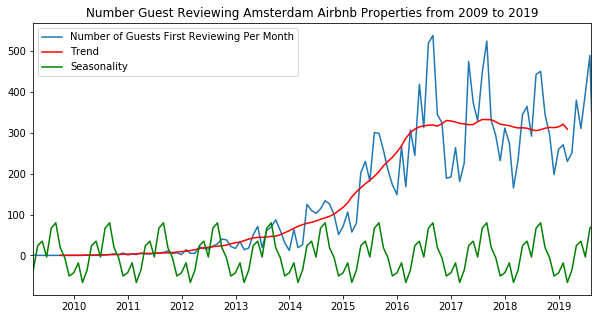

In [52]:
fig, ax = plt.subplots(figsize=(10 , 5))

plt.title('Number Guest Reviewing Amsterdam Airbnb Properties from 2009 to 2019')
plt.plot(df_clean.set_index('first_review').resample('M', 'size'), label = 'Number of Guests First Reviewing Per Month')

# Decompose using additive model
decomp = seasonal_decompose(df_clean.set_index('first_review').resample('M', 'size'))
plt.plot(decomp.trend.index, decomp.trend, c = 'r', label = 'Trend')
plt.plot(decomp.trend.index, decomp.seasonal, c = 'g', label = 'Seasonality')

plt.xlim('2009-03-30', '2019-08-08')
plt.legend()

plt.show()

In [53]:
# What is the peak month of hosts joining?
print('What was the peak month?', np.argmax(df_clean.set_index('first_review').resample('M', 'size')).month)
print('When year was this?', np.argmax(df_clean.set_index('first_review').resample('M', 'size')).year)
print('How many guest first reviewed that month?', df_clean.set_index('first_review').resample('M', 'size').max())

What was the peak month? 8
When year was this? 2016
How many guest first reviewed that month? 539


Generally, guest started reviewing Airbnb homes in Amsterdam from 2015 to 2016. Again, we see a stagnation from 2017 onwards, shown by the trend line. This coincides with the drop and stagnation in the hosts joining. This suggests that though less people were hosting their properties in 2017, guests kept on steadily reviewing the properties that already existed in the listing.

Seasonal-wise, there seems to be a peak of guests reviewing during the fall season, probably after their stay in the Airbnb home during the spring and summer season.

Now that these variables have been looked at, we can drop them from our dataset.

In [54]:
df_clean = df_clean.drop(['host_since', 'last_review', 'first_review'], axis = 1)

## Textual Variables

`description` contains the host's description of the property. 

TODO: Wordcloud

In [55]:
# What variables contain full text?
df_clean['description'].head()

0    Quiet Garden View Room & Super Fast WiFi I'm r...
1    Cozy studio on your own private floor, 100% in...
2    This nicely furnished, newly renovated apt  is...
3    Stylish and romantic houseboat on fantastic hi...
4    In a monumental house right in the center of A...
Name: description, dtype: object

## Location Variables

In [56]:
# What variables deal with the location of the property?
location_vars = ['host_location', 'street', 'neighbourhood_cleansed', 'market', 'smart_location', 'latitude', 'longitude', 'is_location_exact']

## Categorical Variables

In [57]:
# What are the categorical variables? Exclude location variables
categ_vars = [col for col in df_clean.columns if df_clean[col].dtype == 'object' and col not in location_vars]

# Exclude description
categ_vars.remove('description')

print(categ_vars)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'property_type', 'room_type', 'bed_type', 'amenities', 'extra_people', 'calendar_updated', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']


__Question:__ What's the relationship between ratings and `price`?

__Question:__ Does being a superhost get you more guests? How much do they charge? What are their ratings like?

__Question:__ Do hosts who respond better get more reviews? What are the ratings like? How much do responsive hosts charge?

__Question:__ What are host verifications?

In [130]:
df_clean['host_verifications']

0        ['email', 'phone', 'reviews', 'jumio', 'offlin...
1        ['email', 'phone', 'reviews', 'jumio', 'offlin...
2                            ['email', 'phone', 'reviews']
3                   ['email', 'phone', 'reviews', 'jumio']
4                   ['email', 'phone', 'reviews', 'jumio']
                               ...                        
20671                       ['email', 'phone', 'facebook']
20672    ['email', 'phone', 'reviews', 'jumio', 'offlin...
20673                                   ['email', 'phone']
20674    ['email', 'phone', 'reviews', 'jumio', 'govern...
20675    ['email', 'phone', 'google', 'reviews', 'offli...
Name: host_verifications, Length: 20642, dtype: object

__Question:__ How do `amenities` affect `price`? Ratings?

__Question:__ Does having a profile picture get you more guests? 

In order to answer this, I will look at `number_of_reviews` as a measure of the number of guests that used a particular property.

In [86]:
# Boolean encoding
df_clean['host_has_profile_pic'] = df_clean['host_has_profile_pic'].eq('t').mul(1)
num_with_pic = np.count_nonzero(df_clean['host_has_profile_pic'])

In [126]:
pic_data = pd.DataFrame({
    'Has Profile Pic?': ['Yes', 'No'],
    'Amount': [num_with_pic, df_clean.shape[0] - num_with_pic]
})
pic_data = pic_data.set_index('Has Profile Pic?')
pic_data

,Amount
Has Profile Pic?,
Yes,20626
No,16


In [129]:
# How many reviews do hosts with profile pictures get?
has_pic_grouping = df_clean.groupby('host_has_profile_pic')['number_of_reviews'].agg({'num_reviews': np.sum})
has_pic_grouping

,num_reviews
host_has_profile_pic,
0,147
1,480553


We see from the above two dataframes that the vast majority of hosts have a profile picture. Such a huge difference explains the discrepancy between the amount of reviews hosts with a profile picture get versus those without one.

__Question:__ How does the type of property affect `price`? Ratings?

## Qualitative Variables

Before analyzing these variables, I will get rid of the ones that have redundant information. 

In [58]:
df_clean = df_clean.drop(['minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis = 1)

In [59]:
# What are the qualitative variables?
quant_vars = [col for col in df_clean.columns if df_clean[col].dtype != 'object' and col not in location_vars and col not in categ_vars]
quant_vars.remove('log_price')
print(quant_vars)

['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month', 'days_since_first_review', 'days_since_last_review', 'days_as_host']


In [60]:
df_clean[quant_vars].describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,number_of_reviews,calculated_host_listings_count,reviews_per_month,days_since_first_review,days_since_last_review,days_as_host
count,20642.00000,20642.000000,20642.000000,20642.000000,20642.000000,20642.00000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000
mean,2.88005,1.158778,1.454849,1.829958,159.136033,157.74581,32.717033,1.459645,3.547621,617.735152,3.780835,23.287472,4.931063,0.864410,792.310338,253.687240,1611.773375
std,1.31548,0.380305,0.895175,1.408260,162.520608,328.85005,27.352016,0.936088,18.705174,537.972232,7.212555,48.628716,22.902547,1.304176,638.300584,359.853155,716.994960
min,1.00000,0.000000,0.000000,0.000000,9.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.00000,1.000000,1.000000,1.000000,99.000000,0.00000,10.000000,1.000000,2.000000,21.000000,0.000000,2.000000,1.000000,0.140000,232.250000,11.000000,1147.000000
50%,2.00000,1.000000,1.000000,1.000000,130.000000,0.00000,30.000000,1.000000,2.000000,1125.000000,0.000000,9.000000,1.000000,0.430000,735.000000,65.000000,1649.000000
75%,4.00000,1.000000,2.000000,2.000000,180.000000,250.00000,50.000000,2.000000,3.000000,1125.000000,4.000000,23.000000,1.000000,1.000000,1193.000000,368.000000,2151.000000
max,30.00000,15.000000,12.000000,32.000000,8915.000000,4736.00000,531.000000,16.000000,1001.000000,1825.000000,30.000000,767.000000,208.000000,33.670000,3783.000000,2733.000000,3970.000000


### Do the values make sense?

It would also help to check if the distribution of each quantitative variable makes sense. For example, these properties should be able to accommodate at least 1 person. If not, then why is it even a listing on Airbnb? Above, we can see that some variables have a minimum of 0. I talk more about such variables below:



| __Variable__ 	| __Why it might or might not make sense__ 	|
|---------------------	|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `bathrooms` 	| Some of the properties listed might not even be homes. For instance, [this property](https://www.airbnb.com/rooms/1561264?source_impression_id=p3_1588316228_ebF9mlPS0th96fpj&guests=1&adults=1) is a listing for a day out on the lake, where there is no bathroom provided because it is outdoors. 	|
| `bedrooms` 	| Similar to the scenario above, it makes sense that some listings have 0 bedrooms. 	|
| `beds` 	| Again, we see the same scenario. 	|
| `security_deposit` 	| Some properties might not require a security deposit. 	|
| `cleaning_fee` 	| Some properties don't charge a cleaning fee. 	|
| `availability_30` 	| At the time this data was scraped, it could have been the case where there were no listings available in the next 30 days. 	|
| `number_of_reviews` 	| The listings could never have been used. 	|
| `reviews_per_month` 	| As above. 	|
| `days_as_host` 	| The person just became a host the day this was scraped, and just listed their property on that day. 	|



So far, all of the variables make sense in terms of their range.

__Question:__ If a listing accommodates more people, is it more expensive?

Generally, larger properties would be able to accommodate more people, and it is reasonable to assume they would be pricier.

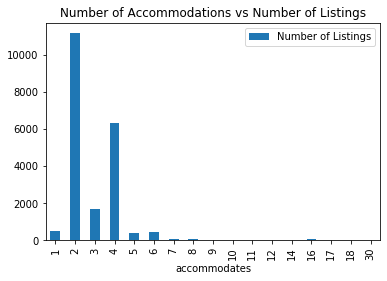

In [61]:
# Get count of listings per number of accommodations
accommodates_num_listings = df_clean.groupby('accommodates').count()[['price']]
accommodates_num_listings = accommodates_num_listings.rename(columns = {'price': 'Number of Listings'})

accommodates_num_listings.plot.bar()
plt.title('Number of Accommodations vs Number of Listings')
plt.show()

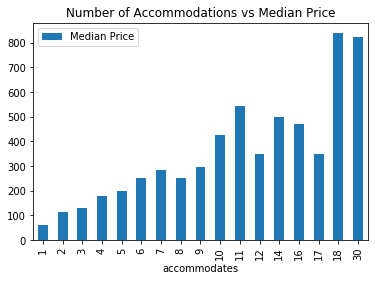

In [62]:
# Get median price of listings per number of accommodations
accommodates_price = df_clean.groupby('accommodates').median()[['price']]
accommodates_price = accommodates_price.rename(columns = {'price': 'Median Price'})

accommodates_price.plot.bar()
plt.title('Number of Accommodations vs Median Price')
plt.show()

The first plot shows that a majority of listings in this dataset could accommodate 2-4 people, which is typical for the size of a home or apartment. This makes sense, as people would most likely use Airbnb homes in small groups for vacation purposes.

The second plot shows that the price does seem to increase as the number of accommodations goes up. The most expensive properties, in terms of median price, were when the properties could house over 10 people. 

__Question:__ Do more experienced hosts charge more?

Using the `days_as_host` variable, I will see if more experienced hosts ie. those with more days as a host, charge more for their properties.

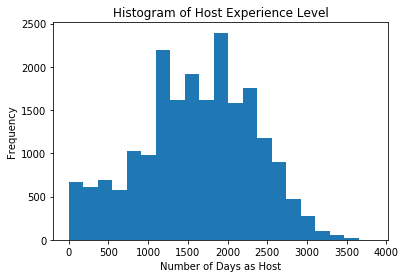

In [65]:
# Histogram of days_as_host
plt.title('Histogram of Host Experience Level')
plt.xlabel('Number of Days as Host')
plt.ylabel('Frequency')
hist_info = plt.hist(df_clean['days_as_host'], bins = np.arange(0, 3970, 365/2))
plt.show()

Each bin in the histogram above represents half a year. We see that most of the hosts have had about 1000 to 2000 days of experience ie. 2 to 5 years of experience. 

In [66]:
bin_values = hist_info[0]
bin_widths = hist_info[1]

In [67]:
# For each bin width, compute median price if days fall in that range
days_as_host_median_prices = []
days_as_host_grouping = df_clean.groupby('days_as_host').size()
for i, bin_width in enumerate(bin_widths[:-1]): # Exclude last value, will compute median later
    left_val = bin_width
    right_val = bin_widths[i + 1]
    
    median_price = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['price'].median()
    days_as_host_median_prices.append(median_price)

# Get median of properties where hosts have more than 3832 days of experience
days_as_host_median_prices.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['price'].median())

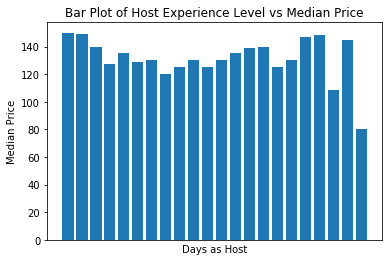

In [68]:
plt.title('Bar Plot of Host Experience Level vs Median Price')
plt.xlabel('Days as Host')
plt.ylabel('Median Price')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_median_prices)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Each bar represents a bin in from the histogram. So, the first bar shows the median price for hosts with at most half a year of experience. From the graph, we can see that hosts, across all experience levels, generally charge the same amount for their properties on Airbnb. Those with the least amount of experience charge slightly more than more experienced hosts, but some hosts with several years of experience charge as much as newcomers.

__Question:__ Do more experienced hosts have more listings?

In [69]:
# For each bin width, compute calculated number of listings if days fall in that range
days_as_host_num_listings = []
for i, bin_width in enumerate(bin_widths[:-1]): # Exclude last value, will compute later
    left_val = bin_width
    right_val = bin_widths[i + 1]

    num_listings = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['calculated_host_listings_count'].sum()
    days_as_host_num_listings.append(num_listings)

# Get median of properties where hosts have more than 3832 days of experience
days_as_host_num_listings.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['calculated_host_listings_count'].sum())

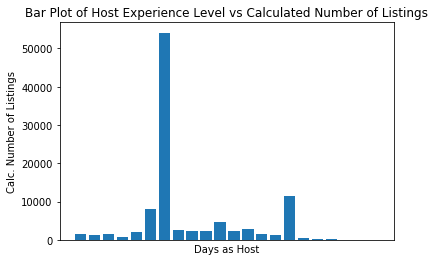

In [70]:
plt.title('Bar Plot of Host Experience Level vs Calculated Number of Listings')
plt.xlabel('Days as Host')
plt.ylabel('Calc. Number of Listings')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_num_listings)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Above is a plot of the host's experience level against the calculated number of listings. Again, each bar represents half a year worth of experience. We can see that the experience level of hosts that have the most number of listings is when they have about 2.5 to 3 years of experience.

__Question:__ Do more experienced hosts have more reviews?

In [71]:
days_as_host_num_reviews = []
for i, bin_width in enumerate(bin_widths[:-1]): 
    left_val = bin_width
    right_val = bin_widths[i + 1]

    num_reviews = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['number_of_reviews'].sum()
    days_as_host_num_reviews.append(num_reviews)

days_as_host_num_reviews.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['number_of_reviews'].sum())

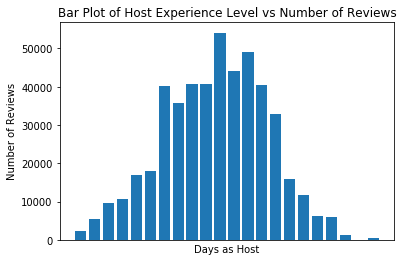

In [72]:
plt.title('Bar Plot of Host Experience Level vs Number of Reviews')
plt.xlabel('Days as Host')
plt.ylabel('Number of Reviews')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_num_reviews)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Above is a plot of the host's experience level versus the number of reviews their listing got. We can see that, generally, more experience hosts get more reviews than newcomers. This makes sense, as newcomers would have just recently posted their property. Why do the most experienced hosts have less reviews? This could be due to the fact that there are not a lot of hosts with years and years of experience. Most have about a two or three years worth of experience.

Let's look at the correlations between the different quantitative variables and `price`.

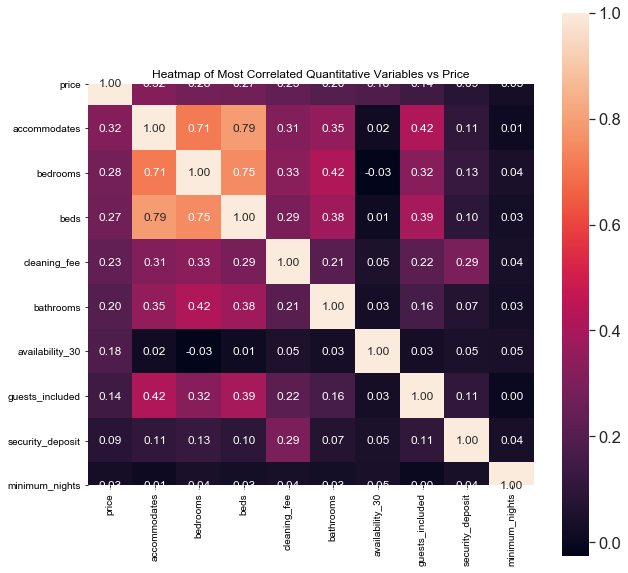

In [73]:
# Get a quick look at the correlations between the quantitative variables and price
corrmat = df_clean[quant_vars].corr()

f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Heatmap of Most Correlated Quantitative Variables vs Price')
k = 10 
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_clean[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the heatmap above, we see that of the quantitative variables, the variable most correlated with `price` is `accommodates`, which corresponds to how many guests the property can accommodate. However, this correlation is not very strong. In fact, most of the variables are not very strongly correlated with `price`. Airbnb hosts can choose how they want to price their properties, which may explain why the correlation is so small. Hosts will price their homes depending on personal opinion, unlike a real-estate agent, who price homes based on experience and the market.  

Above we also see instances of multicollinearity. Specifically, we see that `beds` is strongly correlated with `accommodates`, which makes sense given that if a property can hold more people, then it should have at least have the same amount of beds. 

### Normality Checking

Below, I log-transform non-normal quantitative variables. Note that some variables contained a 0 as a value. In order to transform these, I will create a new column to record whether or not a value exists. Then, on the nonzero values, I will log-transform them.

For example, observations with a `days_as_host` of 0 will be added to and recorded in a new boolean column capturing whether or not the person has been a host. 

In [75]:
# Holds the names of the columns that have a 0
quant_bool_vars = []

# Holds the names of the columns that have been encoded (transformed or not)
quant_vars_enc = []

for var in [bool_var for bool_var in quant_vars if 0 in df_clean[bool_var].values]:
    # Boolean encode
    df_clean['has_' + var] = df_clean[var].apply(lambda x: 1 if x > 0 else 0)
    quant_bool_vars.append('has_' + var)
    
    # Log transform
    if is_normal(df_clean[var]):
        # No need for any transforming
        quant_vars_enc.append(var)
    else:
        # Log transform, create a new column, and append the name to the list
        new_col = var + '_enc'
        df_clean[new_col] = df_clean[var].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
        quant_vars_enc.append(new_col)

print(quant_bool_vars)
print(quant_vars_enc)

['has_bathrooms', 'has_bedrooms', 'has_beds', 'has_security_deposit', 'has_cleaning_fee', 'has_availability_30', 'has_number_of_reviews', 'has_reviews_per_month', 'has_days_since_first_review', 'has_days_since_last_review', 'has_days_as_host']
['bathrooms_enc', 'bedrooms_enc', 'beds_enc', 'security_deposit_enc', 'cleaning_fee_enc', 'availability_30_enc', 'number_of_reviews_enc', 'reviews_per_month_enc', 'days_since_first_review_enc', 'days_since_last_review_enc', 'days_as_host_enc']


# Model Building

regression problem

**ensemble methods**